In [1]:
## Planned datasets - Image (different image sizes/ Different number of classes), 
##                    Classification (Different feature size / Different number of classes)

## Planned models - FC/Dropout, CNN(LeNet)/Resnet/Inception (Maybe include attention)

## Predict running time based on Layers/No of params/FLOPs
## Calculate total number of computations (based on dataset/model size)
## Calculate approx cost on GCP (or any cloud platform)

import tensorflow as tf
import numpy as np
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
import time
import pickle
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings
warnings.filterwarnings("ignore")

In [2]:
def create_fc(config):
    config['hidden_layers'] = len(config['layers'])
    input = tf.keras.layers.Input(shape=config['input_shape'])
    if config['input_dropout'] is not None:
        x = tf.keras.layers.Dropout(config['input_dropout'])(input)
    else:
        x = input
    for i in range(config['hidden_layers']):
        dim = config['layers'][i]
        act = 'relu'
        x = tf.keras.layers.Dense(dim,activation=act)(x)
        if config['dropout'] is not None:
            x = tf.keras.layers.Dropout(config['dropout'])(x)
            
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Dense(config['output_shape'],activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=x)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                                metrics=['accuracy'])
    return model

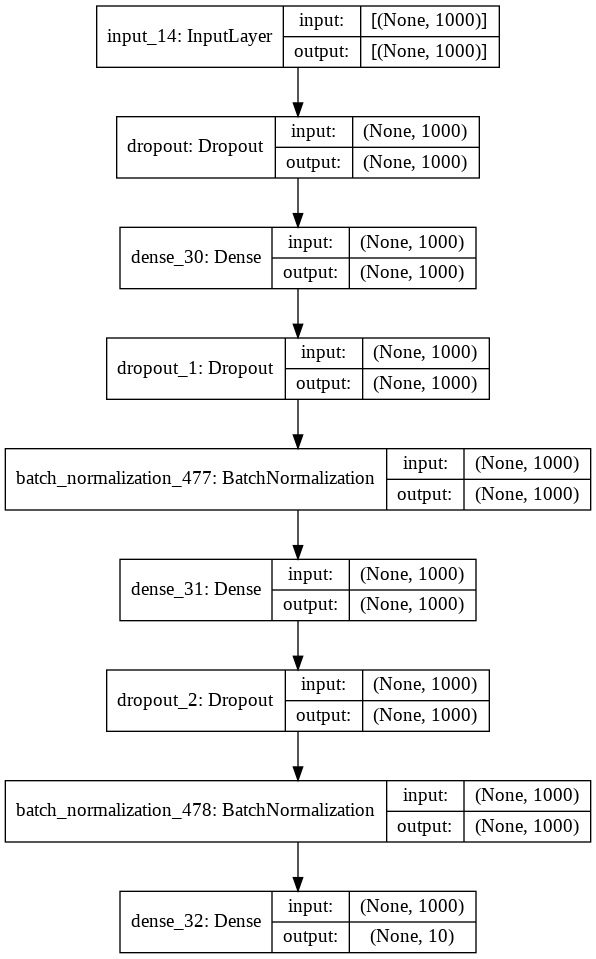

In [57]:
fc_config = dict()
fc_config['input_shape'] = 1000
fc_config['output_shape'] = 10
fc_config['input_dropout'] = 0.2
fc_config['dropout'] = 0.5
fc_config['hidden_layers'] = 2
fc_config['layers'] = [1000,1000]
# Output activation = always sigmoid
# All hidden layers have same dropout
# All hidden layers activated with ReLU
# Optimizer is always sgd with lr = 0.01 and momentum=0.9

fc_model = create_fc(fc_config)

tf.keras.utils.plot_model(fc_model,show_shapes=True)

In [3]:
def vgg_block(x, filters, layers):
    for _ in range(layers):
        x = tf.keras.layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2), strides=(2,2))(x)
    return x

def create_vgg(config):
    config['num_layers'] = len(config['vgg_layers'])
    input = tf.keras.layers.Input(shape=config['input_shape'])
    x = input
    for i in range(config['num_layers']):
        block_size = config['vgg_layers'][i]
        filter_num = config['filters'][i]
        act = 'relu'
        x = vgg_block(x,filter_num,block_size)
    x = tf.keras.layers.Flatten()(x)
    config['num_hidden_layers'] = len(config['hidden_layers'])
    for i in range(config['num_hidden_layers']):
        dim = config['hidden_layers'][i]
        act = 'relu'
        x = tf.keras.layers.Dense(dim,activation=act)(x)

    x = tf.keras.layers.Dense(config['output_shape'],activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=x)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                                metrics=['accuracy'])
    return model

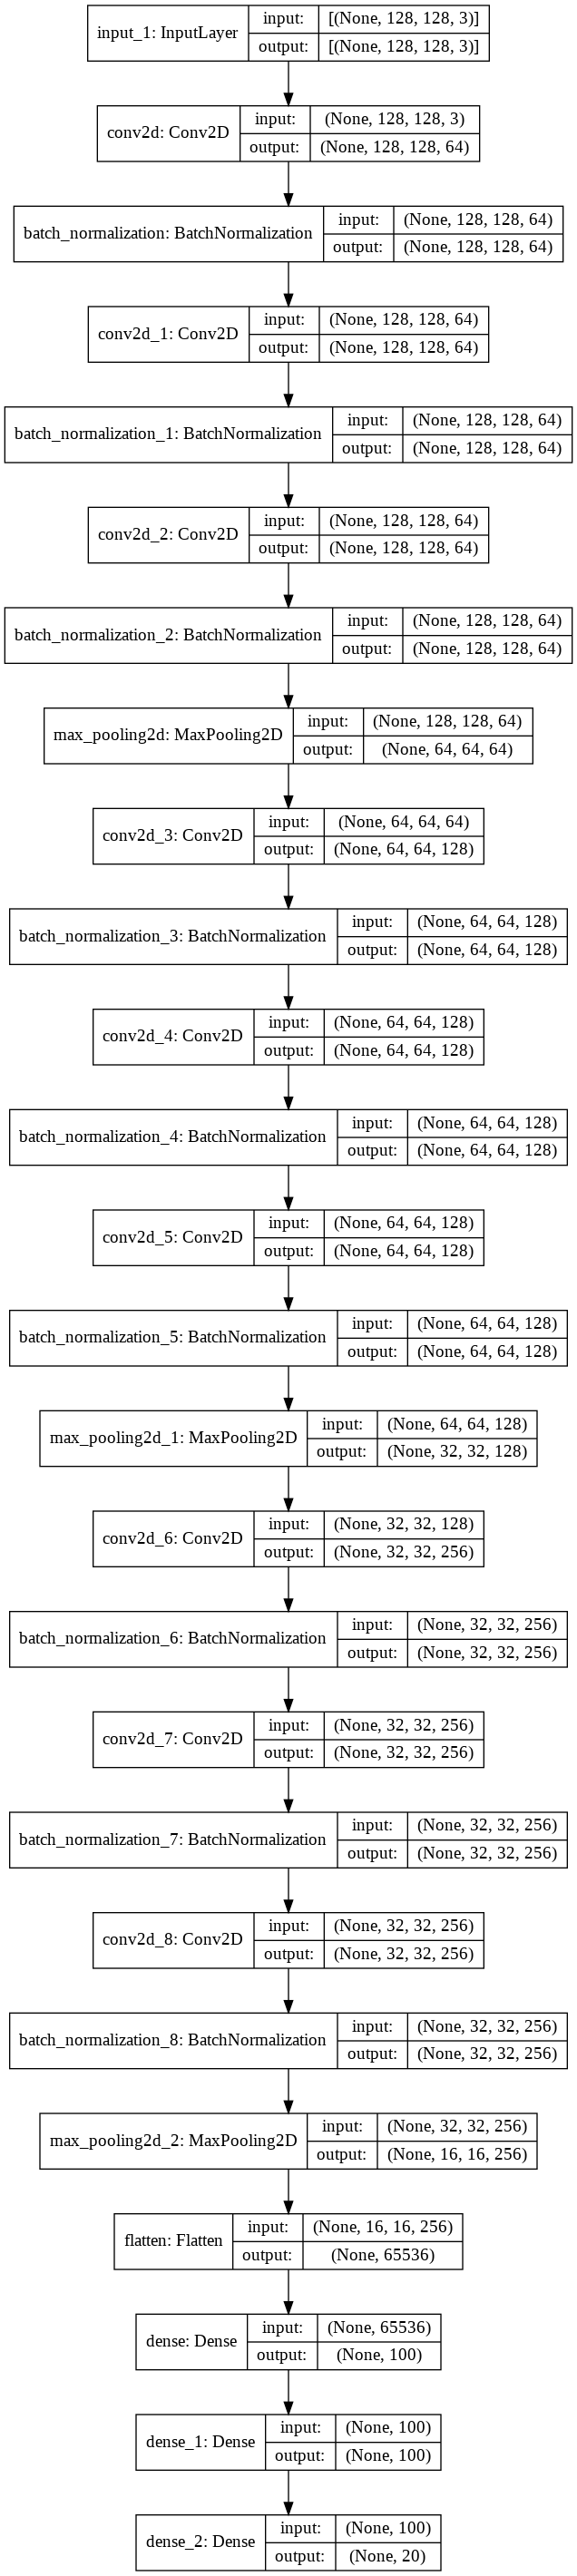

In [3]:
vgg_config = dict()
vgg_config['input_shape'] = (128,128,3)
vgg_config['vgg_layers'] = [3,3,3]
vgg_config['filters'] = [64,128,256]
vgg_config['hidden_layers'] = [100,100]
vgg_config['output_shape'] = 20
# Output activation = always sigmoid
# All convolution layers have 3x3 kernel and same padding
# All pooling layers (end of VGG block) reduce image size by half
# All hidden layers activated with ReLU
# Optimizer is always sgd with lr = 0.01 and momentum=0.9

vgg_model = create_vgg(vgg_config)

tf.keras.utils.plot_model(vgg_model,show_shapes=True)

In [4]:
def inception_block(x, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = tf.keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    # 3x3 conv
    conv3 = tf.keras.layers.Conv2D(f2_in, (1,1), padding='same', activation='relu')(x)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    # 5x5 conv
    conv5 = tf.keras.layers.Conv2D(f3_in, (1,1), padding='same', activation='relu')(x)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    # 3x3 max pooling
    pool = tf.keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool = tf.keras.layers.Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    pool = tf.keras.layers.BatchNormalization()(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = tf.keras.layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

def create_inception(config):
    config['num_layers'] = len(config['inception_layers'])
    input = tf.keras.layers.Input(shape=config['input_shape'])
    x = tf.keras.layers.Conv2D(64, (7,7), padding='valid', activation='relu', strides=(2,2))(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = tf.keras.layers.Conv2D(128, (1,1), padding='same', activation='relu', strides=(1,1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(192, (3,3), padding='same', activation='relu', strides=(1,1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    for i in range(config['num_layers']):
        for j in range(config['inception_layers'][i]):
            x = inception_block(x,config['f1'][i][j],config['f2_in'][i][j],config['f2_out'][i][j],
                                                    config['f3_in'][i][j],config['f3_out'][i][j],config['f4_out'][i][j])
        x = tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    config['num_hidden_layers'] = len(config['hidden_layers'])
    for i in range(config['num_hidden_layers']):
        dim = config['hidden_layers'][i]
        act = 'relu'
        x = tf.keras.layers.Dense(dim,activation=act)(x)

    x = tf.keras.layers.Dense(config['output_shape'],activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=x)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                                metrics=['accuracy'])
    return model

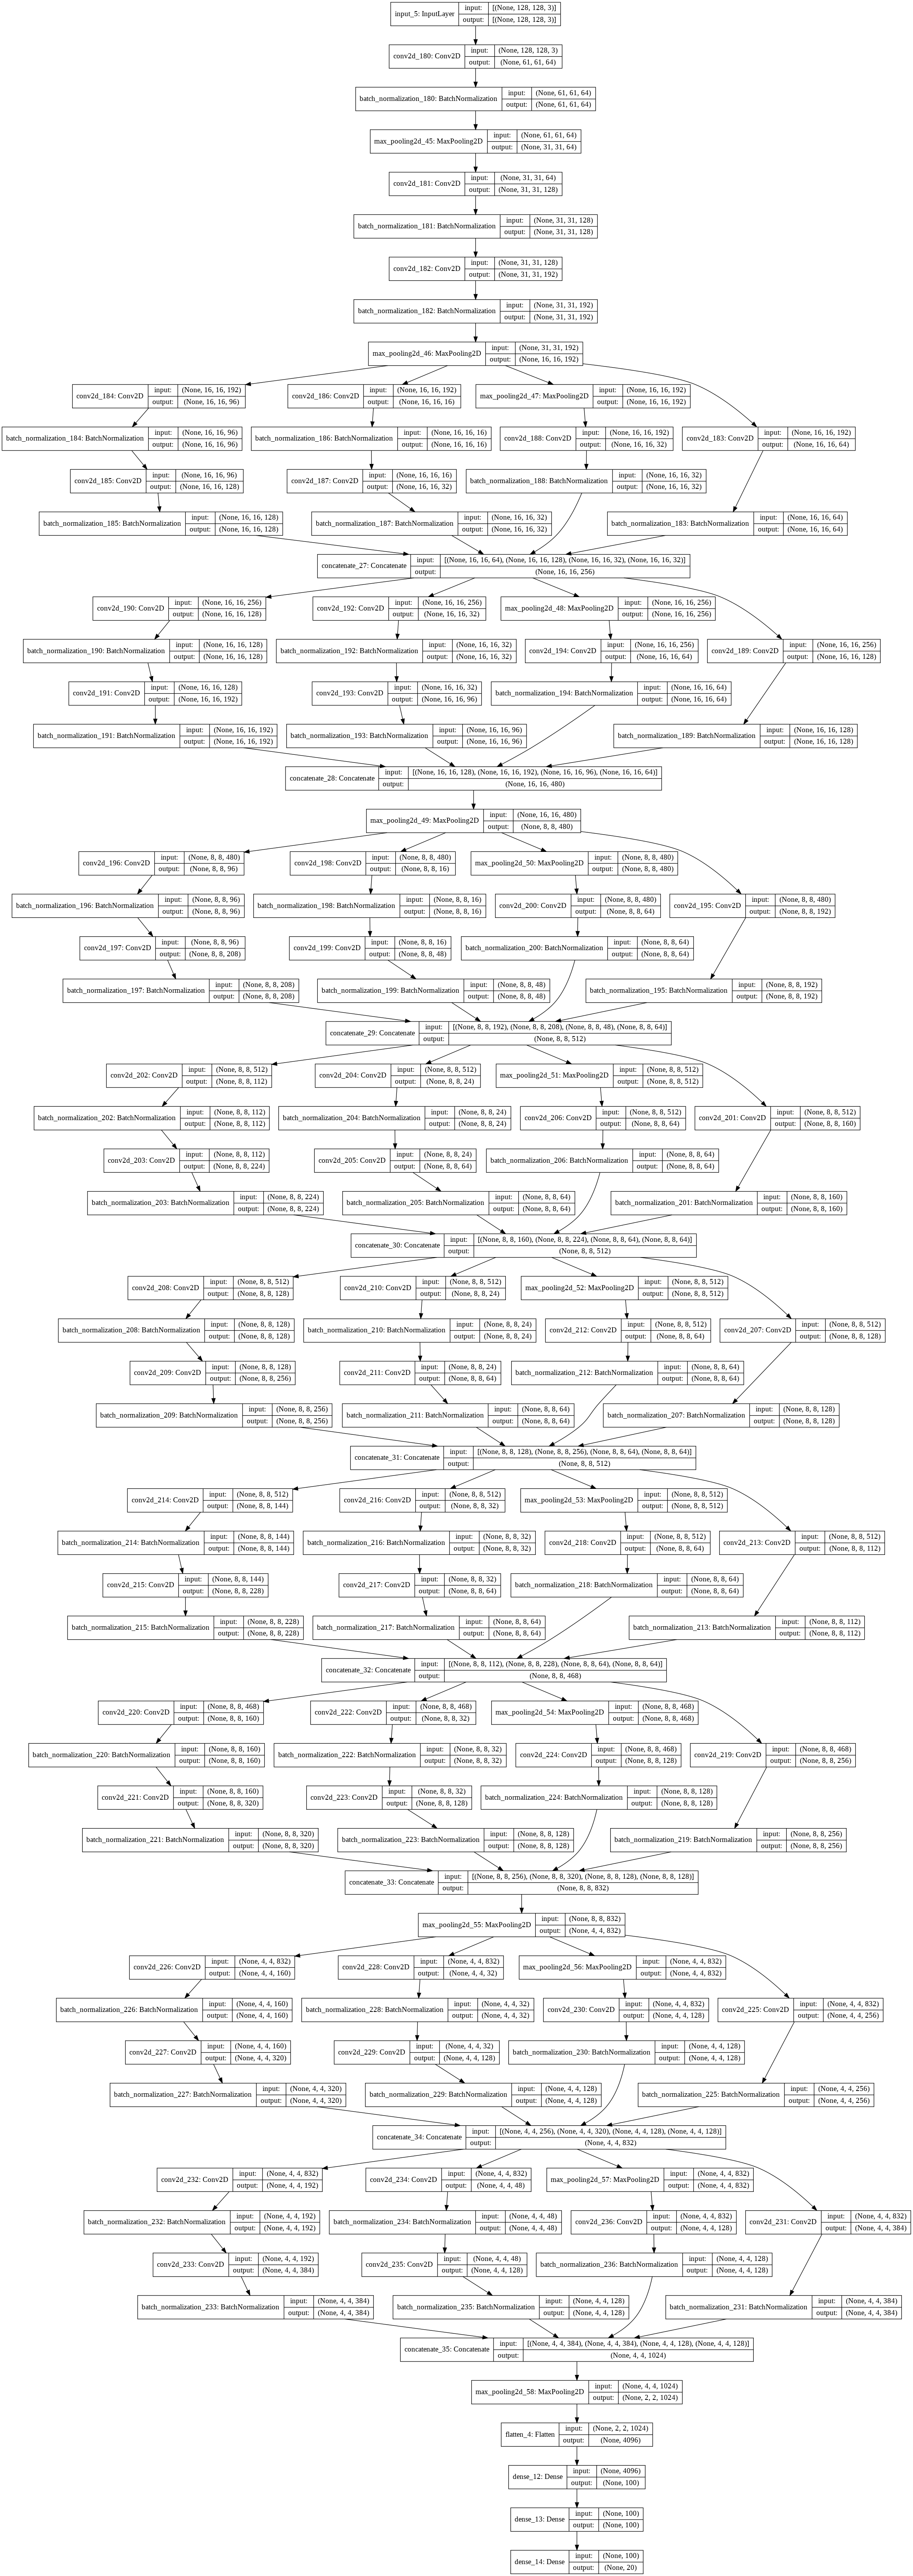

In [19]:
inception_config = dict()
inception_config['input_shape'] = (128,128,3)
inception_config['inception_layers'] = [2,5,2]
inception_config['f1'] = [[64,128],[192,160,128,112,256],[256,384]]
inception_config['f2_in'] = [[96,128],[96,112,128,144,160],[160,192]]
inception_config['f2_out'] = [[128,192],[208,224,256,228,320],[320,384]]
inception_config['f3_in'] = [[16,32],[16,24,24,32,32],[32,48]]
inception_config['f3_out'] = [[32,96],[48,64,64,64,128],[128,128]]
inception_config['f4_out'] = [[32,64],[64,64,64,64,128],[128,128]]
inception_config['hidden_layers'] = [100,100]
inception_config['output_shape'] = 20
# Output activation = always sigmoid
# All convolution layers have 3x3 kernel and same padding
# All pooling layers (end of VGG block) reduce image size by half
# All hidden layers activated with ReLU
# Optimizer is always sgd with lr = 0.01 and momentum=0.9

inception_model = create_inception(inception_config)
# inception_model.summary()

tf.keras.utils.plot_model(inception_model,show_shapes=True)

In [5]:
def conv_relu(x, filters, kernel_size, strides=1):
        
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding = 'same')(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.BatchNormalization()(x)
        return x

def identity_block(tensor, filters):
        
        x = conv_relu(tensor, filters=filters, kernel_size=1, strides=1)
        x = conv_relu(x, filters=filters, kernel_size=3, strides=1)
        x = tf.keras.layers.Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Add()([tensor,x])
        x = tf.keras.layers.ReLU()(x)
        
        return x

def identity_block_small(tensor, filters):
        
        x = conv_relu(tensor, filters=filters, kernel_size=3, strides=1)
        x = conv_relu(x, filters=filters, kernel_size=3, strides=1)
        
        x = tf.keras.layers.Add()([tensor,x])
        x = tf.keras.layers.ReLU()(x)
        
        return x

def projection_block(tensor, filters, strides):
        
        x = conv_relu(tensor, filters=filters, kernel_size=1, strides=strides)
        x = conv_relu(x, filters=filters, kernel_size=3, strides=1)
        x = tf.keras.layers.Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        shortcut = tf.keras.layers.Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
        
        x = tf.keras.layers.Add()([shortcut,x])
        x = tf.keras.layers.ReLU()(x)
        
        return x

def projection_block_small(tensor, filters, strides):
        
        x = conv_relu(tensor, filters=filters, kernel_size=3, strides=strides)
        x = conv_relu(x, filters=filters, kernel_size=3, strides=1)
        
        shortcut = tf.keras.layers.Conv2D(filters=filters, kernel_size=1, strides=strides)(tensor)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
        
        x = tf.keras.layers.Add()([shortcut,x])
        x = tf.keras.layers.ReLU()(x)
        
        return x

def resnet_block(x, filters, reps, strides):
        
        x = projection_block(x, filters, strides)
        for _ in range(reps-1):
                x = identity_block(x,filters)
                
        return x

def resnet_block_small(x, filters, reps, strides):
        
        x = projection_block_small(x, filters, strides)
        for _ in range(reps):
                x = identity_block_small(x,filters)
                
        return x

def resnet(config):

    input = tf.keras.layers.Input(shape=config['input_shape'])

    x = conv_relu(input, filters=64, kernel_size=7, strides=2)
    x = tf.keras.layers.MaxPool2D(pool_size = 3, strides =2)(x)
    if config['small']==False:
            x = resnet_block(x, filters=64, reps=config['resnet_layers'][0], strides=1)
            x = resnet_block(x, filters=128, reps=config['resnet_layers'][1], strides=2)
            x = resnet_block(x, filters=256, reps=config['resnet_layers'][2], strides=2)
            x = resnet_block(x, filters=512, reps=config['resnet_layers'][3], strides=2)
    else:
            x = resnet_block_small(x, filters=64, reps=config['resnet_layers'][0], strides=1)
            x = resnet_block_small(x, filters=128, reps=config['resnet_layers'][1], strides=2)
            x = resnet_block_small(x, filters=256, reps=config['resnet_layers'][2], strides=2)
            x = resnet_block_small(x, filters=512, reps=config['resnet_layers'][3], strides=2)
    x = tf.keras.layers.GlobalAvgPool2D()(x)

    config['num_hidden_layers'] = len(config['hidden_layers'])
    for i in range(config['num_hidden_layers']):
        dim = config['hidden_layers'][i]
        act = 'relu'
        x = tf.keras.layers.Dense(dim,activation=act)(x)

    output = tf.keras.layers.Dense(config['output_shape'], activation ='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                            optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                            metrics=['accuracy'])
    return model

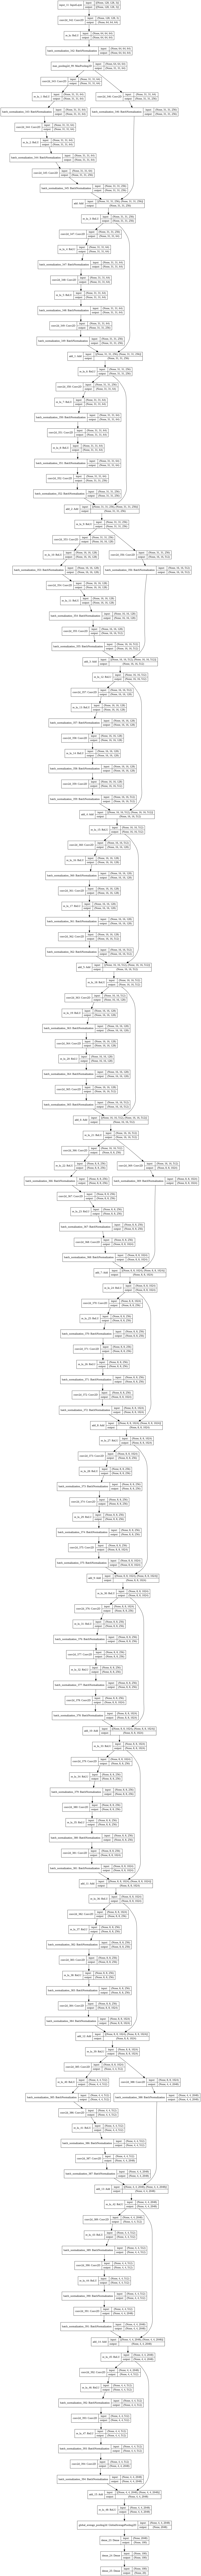

In [39]:
resnet_config = dict()
resnet_config['input_shape'] = (128,128,3)
resnet_config['small'] = False
resnet_config['resnet_layers'] = [3,4,6,3]
resnet_config['hidden_layers'] = [100,100]
resnet_config['output_shape'] = 20
resnet_model = resnet(resnet_config)
# Output activation = always sigmoid
# All resnet blocks have same structure. Can only specify number of repeating blocks (4 list)
# Can also specify if small architecture or not (refer paper)
# All hidden layers activated with ReLU
# Optimizer is always sgd with lr = 0.01 and momentum=0.9

tf.keras.utils.plot_model(resnet_model,show_shapes=True)

In [36]:
# Some more Common Functions

In [6]:
def get_flops(model, batch_size=None,allowed_flops=['MatMul', 'Mul', 'Rsqrt', 'BiasAdd', 'Sub', 'Softmax', 'Conv2D', 'MaxPool', 'Mean']):
    if batch_size is None:
        batch_size = 1

    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    opts['output'] = 'none'
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                            run_meta=run_meta, cmd='op', options=opts)
    
    ret_val = dict()
    for fl in allowed_flops:
        ret_val[fl] = 0
    f = flops.children
    while(len(f) > 0):
        if f[0].name in allowed_flops:
            ret_val[f[0].name] = f[0].total_float_ops
        f = f[0].children
    return ret_val

In [7]:
def get_weights(model):
    ret_val = dict()
    ret_val['trainable'] = np.sum([np.product([xi for xi in x.get_shape()]) for x in model.trainable_weights])
    ret_val['non_trainable'] = np.sum([np.product([xi for xi in x.get_shape()]) for x in model.non_trainable_weights])
    return ret_val

In [8]:
def get_layers(model):
    ret_val = dict()
    for l in model.layers:
        name = l.__class__.__name__
        if name in ret_val:
            ret_val[name] += 1
        else:
            ret_val[name] = 1
    return ret_val

In [9]:
allowed_flops = ['MatMul', 'Mul', 'Rsqrt', 'BiasAdd', 'Sub', 'Softmax', 'Conv2D', 'MaxPool', 'Mean']
def get_model_params(model,batch_size = 64,x_shape=[]):
    flops = get_flops(model)
    weights = get_weights(model)
    layers = get_layers(model)
    
    return flops,weights,layers

In [10]:
def create_image_dataset(config):
    input_shape = [128] + list(config['input_shape'])
    output_shape = [128] + [config['output_shape']]
    batch_size = config['batch_size']
    x = tf.random.uniform(shape=input_shape)
    y = tf.random.uniform(shape=output_shape)
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    
    return dataset

In [11]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.perf_counter()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.perf_counter() - self.epoch_time_start)

In [12]:
# VGG Runs

In [13]:
def run_vgg(config):
    model = create_vgg(config)
    flops,weights,layers = get_model_params(model)
    config['flops_param'] = flops
    config['weights_param'] = weights
    config['layers_param'] = layers
    dataset = create_image_dataset(config)
    time_callback = TimeHistory()
    steps_per_epoch = config['input_size'] // config['batch_size']
    hist = model.fit(dataset,steps_per_epoch=steps_per_epoch, epochs=6, callbacks = [time_callback],verbose=False)
    config['train_times'] = time_callback.times[1:]
    flops,weights,layers = get_model_params(model)
    return config

In [14]:
vgg_range = dict()
vgg_range['input_shape'] = [128,1024,15,0]
vgg_range['input_size'] = [10,19,10,1] # Logspace 9
vgg_range['vgg_layers'] = [2,10,9,0]
vgg_range['vgg_layers_size'] = [1,7,7,0] 
vgg_range['filters'] = [4,10,7,1] # Logspace 8
vgg_range['hidden_layers_size'] = [1,10,10,0]
vgg_range['hidden_layers'] = [2,3.5,4,2] # Logspace 7
vgg_range['output_shape'] = [1,10,10,1] # Logspace 10
vgg_range['batch_size'] = [3,10,8,1] #Logspace 8

In [15]:
vgg_params = dict()
for key in vgg_range.keys():
    val = vgg_range[key]
    if val[-1] == 0:
        vgg_params[key] = np.linspace(val[0],val[1],num=val[2]).astype('int')
    elif val[-1] == 1:
        vgg_params[key] = np.logspace(val[0],val[1],num=val[2],base=2).astype('int')
    elif val[-1] == 2:
        vgg_params[key] = np.logspace(val[0],val[1],num=val[2],base=10).astype('int')

for k,v in vgg_params.items():
    print(k,v) 

input_shape [ 128  192  256  320  384  448  512  576  640  704  768  832  896  960
 1024]
input_size [  1024   2048   4096   8192  16384  32768  65536 131072 262144 524288]
vgg_layers [ 2  3  4  5  6  7  8  9 10]
vgg_layers_size [1 2 3 4 5 6 7]
filters [  16   32   64  128  256  512 1024]
hidden_layers_size [ 1  2  3  4  5  6  7  8  9 10]
hidden_layers [ 100  316 1000 3162]
output_shape [   2    4    8   16   32   64  128  256  512 1024]
batch_size [   8   16   32   64  128  256  512 1024]


In [16]:
def create_base_params(params):
    config = dict()
    for k,v in params.items():
        config[k] = v[0]
    return config

def create_base_vgg_config(params):
    config = dict()
    config['input_shape'] = (params['input_shape'],params['input_shape'],3)
    config['vgg_layers'] = [params['vgg_layers']] * params['vgg_layers_size']

    filters = []
    for i in range(params['vgg_layers_size']):
        filters.append(params['filters']*(2**i))
    config['filters'] = filters

    config['hidden_layers'] = [params['hidden_layers']] * params['hidden_layers_size']
    config['output_shape'] = params['output_shape']

    config['input_size'] = params['input_size']
    config['batch_size'] = params['batch_size']
    
    config['model'] = "VGG"
    return config

In [17]:
%%time
for key in vgg_params:
    base_param = create_base_params(vgg_params)
    for value in vgg_params[key]:
        print(f'Running {key} : {value}')
        filename = f'vgg/vgg-{key}-{value}.pickle'
        if os.path.exists(filename):
            with open(filename, 'rb') as handle:
                output_config = pickle.load(handle)
                print(output_config['train_times'])
            continue
        base_param[key] = value
        output_config = run_vgg(create_base_vgg_config(base_param))
        print(output_config['train_times'])
        with open(filename, 'wb') as handle:
            pickle.dump(output_config, handle, protocol=pickle.HIGHEST_PROTOCOL)

Running input_shape : 128
[0.3916321119759232, 0.39553387300111353, 0.3950996819185093, 0.38934413401875645, 0.3949540989706293]
Running input_shape : 192
[0.6099827110301703, 0.606804950046353, 0.6062071389751509, 0.6065830120351166, 0.6069266609847546]
Running input_shape : 256
[1.0368596889311448, 1.0345028389710933, 1.0324806940043345, 1.033559113042429, 1.0405177630018443]
Running input_shape : 320
[1.5546555001055822, 1.551045150961727, 1.555262957001105, 1.5571821039775386, 1.5457048660609871]
Running input_shape : 384
[2.1733344619860873, 2.1713483199710026, 2.162825181032531, 2.1684381559025496, 2.176667663967237]
Running input_shape : 448
[2.9236437019426376, 2.9092045120196417, 2.9215058309491724, 2.92243217502255, 2.9139350689947605]
Running input_shape : 512
[3.801165034994483, 3.7916545699117705, 3.7915887139970437, 3.7781323199160397, 3.784044793108478]
Running input_shape : 576
[4.772432354977354, 4.774310717009939, 4.763080995995551, 4.792407160974108, 4.77216711407527

In [18]:
# Inception Runs

In [19]:
def create_base_params(params):
    config = dict()
    for k,v in params.items():
        config[k] = v[0]
    return config

def create_base_inception_config(params):
    config = dict()
    config['input_shape'] = (params['input_shape'],params['input_shape'],3)
    config['inception_layers'] = [params['inception_layers']] * 3

    config['f1'] = []
    config['f2_in'] = []
    config['f2_out'] = []
    config['f3_in'] = []
    config['f3_out'] = []
    config['f4_out'] = []

    for val in config['inception_layers']:
        config['f1'].append([params['f1']]*val)
        config['f2_in'].append([params['f2_in']]*val)
        config['f2_out'].append([params['f2_out']]*val)
        config['f3_in'].append([params['f3_in']]*val)
        config['f3_out'].append([params['f3_out']]*val)
        config['f4_out'].append([params['f4_out']]*val)

    config['hidden_layers'] = [params['hidden_layers']] * params['hidden_layers_size']
    config['output_shape'] = params['output_shape']

    config['input_size'] = params['input_size']
    config['batch_size'] = params['batch_size']
    
    config['model'] = "Inception"
    return config

In [20]:
def run_inception(config):
    model = create_inception(config)
    flops,weights,layers = get_model_params(model)
    config['flops_param'] = flops
    config['weights_param'] = weights
    config['layers_param'] = layers
    dataset = create_image_dataset(config)
    time_callback = TimeHistory()
    steps_per_epoch = config['input_size'] // config['batch_size']
    hist = model.fit(dataset,steps_per_epoch=steps_per_epoch, epochs=6, callbacks = [time_callback],verbose=False)
    config['train_times'] = time_callback.times[1:]
    return config

In [21]:
inception_range = dict()
inception_range['input_shape'] = [128,1024,15,0]
inception_range['input_size'] = [10,19,10,1] # Logspace 9
inception_range['inception_layers'] = [1,5,5,0]
inception_range['f1'] = [64,320,5,0]
inception_range['f2_in'] = [128,384,5,0]
inception_range['f2_out'] = [192,448,5,0]
inception_range['f3_in'] = [32,160,5,0]
inception_range['f3_out'] = [32,160,5,0]
inception_range['f4_out'] = [32,160,5,0]
inception_range['hidden_layers_size'] = [1,10,10,0]
inception_range['hidden_layers'] = [2,3.5,4,2] # Logspace 7
inception_range['output_shape'] = [1,10,10,1] # Logspace 10
inception_range['batch_size'] = [3,10,8,1] #Logspace 8

In [22]:
inception_params = dict()
for key in inception_range.keys():
    val = inception_range[key]
    if val[-1] == 0:
        inception_params[key] = np.linspace(val[0],val[1],num = val[2]).astype('int')
    elif val[-1] == 1:
        inception_params[key] = np.logspace(val[0],val[1],num = val[2],base = 2).astype('int')
    elif val[-1] == 2:
        inception_params[key] = np.logspace(val[0],val[1],num = val[2],base = 10).astype('int')

for k,v in inception_params.items():
    print(k,v) 

input_shape [ 128  192  256  320  384  448  512  576  640  704  768  832  896  960
 1024]
input_size [  1024   2048   4096   8192  16384  32768  65536 131072 262144 524288]
inception_layers [1 2 3 4 5]
f1 [ 64 128 192 256 320]
f2_in [128 192 256 320 384]
f2_out [192 256 320 384 448]
f3_in [ 32  64  96 128 160]
f3_out [ 32  64  96 128 160]
f4_out [ 32  64  96 128 160]
hidden_layers_size [ 1  2  3  4  5  6  7  8  9 10]
hidden_layers [ 100  316 1000 3162]
output_shape [   2    4    8   16   32   64  128  256  512 1024]
batch_size [   8   16   32   64  128  256  512 1024]


In [ ]:
%%time
for key in inception_params:
    base_param = create_base_params(inception_params)
    for value in inception_params[key]:
        print(f'Running {key} : {value}')
        filename = f'inception/inception-{key}-{value}.pickle'
        if os.path.exists(filename):
            with open(filename, 'rb') as handle:
                output_config = pickle.load(handle)
                print(output_config['train_times'])
            continue
        base_param[key] = value
        output_config = run_inception(create_base_inception_config(base_param))
        print(output_config['train_times'])
        with open(filename, 'wb') as handle:
            pickle.dump(output_config, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
# ResNet Runs

In [49]:
def create_base_params(params):
    config = dict()
    for k,v in params.items():
        config[k] = v[0]
    return config

def create_base_resnet_config(params):
    config = dict()
    config['input_shape'] = (params['input_shape'],params['input_shape'],3)
    config['small'] = False
    config['resnet_layers'] = [params['resnet_layers']] * 4

    config['hidden_layers'] = [params['hidden_layers']] * params['hidden_layers_size']
    config['output_shape'] = params['output_shape']

    config['input_size'] = params['input_size']
    config['batch_size'] = params['batch_size']
    
    config['model'] = "ResNet"
    return config

In [50]:
def run_resnet(config):
    model = resnet(config)
    flops,weights,layers = get_model_params(model)
    config['flops_param'] = flops
    config['weights_param'] = weights
    config['layers_param'] = layers
    dataset = create_image_dataset(config)
    time_callback = TimeHistory()
    steps_per_epoch = config['input_size'] // config['batch_size']
    hist = model.fit(dataset,steps_per_epoch=steps_per_epoch, epochs=6, callbacks = [time_callback],verbose=False)
    config['train_times'] = time_callback.times[1:]
    return config

In [51]:
resnet_range = dict()
resnet_range['input_shape'] = [128,1024,15,0]
resnet_range['input_size'] = [10,19,10,1] # Logspace 9
resnet_range['resnet_layers'] = [3,7,5,0]
resnet_range['hidden_layers_size'] = [1,10,10,0]
resnet_range['hidden_layers'] = [2,3.5,4,2] # Logspace 7
resnet_range['output_shape'] = [1,10,10,1] # Logspace 10
resnet_range['batch_size'] = [3,10,8,1] #Logspace 8

In [52]:
resnet_params = dict()
for key in resnet_range.keys():
    val = resnet_range[key]
    if val[-1] == 0:
        resnet_params[key] = np.linspace(val[0],val[1],num = val[2]).astype('int')
    elif val[-1] == 1:
        resnet_params[key] = np.logspace(val[0],val[1],num = val[2],base = 2).astype('int')
    elif val[-1] == 2:
        resnet_params[key] = np.logspace(val[0],val[1],num = val[2],base = 10).astype('int')

for k,v in resnet_params.items():
    print(k,v) 

input_shape [ 128  192  256  320  384  448  512  576  640  704  768  832  896  960
 1024]
input_size [  1024   2048   4096   8192  16384  32768  65536 131072 262144 524288]
resnet_layers [3 4 5 6 7]
hidden_layers_size [ 1  2  3  4  5  6  7  8  9 10]
hidden_layers [ 100  316 1000 3162]
output_shape [   2    4    8   16   32   64  128  256  512 1024]
batch_size [   8   16   32   64  128  256  512 1024]


In [ ]:
%%time
for key in resnet_params:
    base_param = create_base_params(resnet_params)
    for value in resnet_params[key]:
        print(f'Running {key} : {value}')
        filename = f'resnet/resnet-{key}-{value}.pickle'
        if os.path.exists(filename):
            with open(filename, 'rb') as handle:
                output_config = pickle.load(handle)
                print(output_config['train_times'])
            continue
        base_param[key] = value
        output_config = run_resnet(create_base_resnet_config(base_param))
        print(output_config['train_times'])
        with open(filename, 'wb') as handle:
            pickle.dump(output_config, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
# FC Runs

In [64]:
def create_base_params(params):
    config = dict()
    for k,v in params.items():
        config[k] = v[0]
    return config

def create_base_fc_config(params):
    config = dict()
    config['input_shape'] = params['input_shape']
    config['input_dropout'] = 0.2
    config['dropout'] = 0.5

    config['layers'] = [1000] * params['hidden_layers']
    config['output_shape'] = params['output_shape']

    config['input_size'] = params['input_size']
    config['batch_size'] = params['batch_size']
    
    config['model'] = "FC"
    return config

In [65]:
def run_fc(config):
    model = create_fc(config)
    flops,weights,layers = get_model_params(model)
    config['flops_param'] = flops
    config['weights_param'] = weights
    config['layers_param'] = layers
    dataset = create_image_dataset(config)
    time_callback = TimeHistory()
    steps_per_epoch = config['input_size'] // config['batch_size']
    hist = model.fit(dataset,steps_per_epoch=steps_per_epoch, epochs=6, callbacks = [time_callback],verbose=False)
    config['train_times'] = time_callback.times[1:]
    return config

In [66]:
fc_range = dict()
fc_range['input_shape'] = [128,1024,15,0]
fc_range['input_size'] = [10,19,10,1] # Logspace 9
fc_range['hidden_layers'] = [1,10,10,0]
fc_range['output_shape'] = [1,10,10,1] # Logspace 10
fc_range['batch_size'] = [3,10,8,1] #Logspace 8

In [67]:
fc_params = dict()
for key in fc_range.keys():
    val = fc_range[key]
    if val[-1] == 0:
        fc_params[key] = np.linspace(val[0],val[1],num = val[2]).astype('int')
    elif val[-1] == 1:
        fc_params[key] = np.logspace(val[0],val[1],num = val[2],base = 2).astype('int')
    elif val[-1] == 2:
        fc_params[key] = np.logspace(val[0],val[1],num = val[2],base = 10).astype('int')

for k,v in fc_params.items():
    print(k,v) 

input_shape [ 128  192  256  320  384  448  512  576  640  704  768  832  896  960
 1024]
input_size [  1024   2048   4096   8192  16384  32768  65536 131072 262144 524288]
hidden_layers [ 1  2  3  4  5  6  7  8  9 10]
output_shape [   2    4    8   16   32   64  128  256  512 1024]
batch_size [   8   16   32   64  128  256  512 1024]


In [ ]:
%%time
for key in fc_params:
    base_param = create_base_params(fc_params)
    for value in fc_params[key]:
        print(f'Running {key} : {value}')
        filename = f'fc/fc-{key}-{value}.pickle'
        if os.path.exists(filename):
            with open(filename, 'rb') as handle:
                output_config = pickle.load(handle)
                print(output_config['train_times'])
            continue
        base_param[key] = value
        output_config = run_fc(create_base_fc_config(base_param))
        print(output_config['train_times'])
        with open(filename, 'wb') as handle:
            pickle.dump(output_config, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Planned parameters : 

1. Number of cov layers
2. Number of dense layers
3. Number of total layers

4. Conv2D flops
5. MaxPool flops
6. Bias Addition flops
8. Matrix Multiplication flops
7. Mean Flops
8. Softmax Flops

9. Dataset shape (image - max(width,height), fc - input dimension)
10. Number of training images
11. Output dimensions
----------
12. Model Type
13. Batch Size

Include Batch norm (after every layer)

### Models

1. Fully connected

fc_config['input_shape'] = 1000 <br>
fc_config['output_shape'] = 10 <br>
fc_config['input_dropout'] = 0.2 <br>
fc_config['dropout'] = 0.5 <br>
fc_config['hidden_layers'] = 2 <br>
fc_config['layers'] = [1000,1000] <br>

2. VGG

vgg_config['input_shape'] = (128,128,3) <br>
vgg_config['vgg_layers'] = [3,3,3] <br>
vgg_config['filters'] = [64,128,256] <br>
vgg_config['hidden_layers'] = [100,100] <br>
vgg_config['output_shape'] = 20 <br>

3. Inception Network

inception_config['input_shape'] = (128,128,3) <br>
inception_config['inception_layers'] = [2,5,2] <br>
inception_config['f1'] = [[64,128],[192,160,128,112,256],[256,384]] <br>
inception_config['f2_in'] = [[96,128],[96,112,128,144,160],[160,192]] <br>
inception_config['f2_out'] = [[128,192],[208,224,256,228,320],[320,384]] <br>
inception_config['f3_in'] = [[16,32],[16,24,24,32,32],[32,48]] <br>
inception_config['f3_out'] = [[32,96],[48,64,64,64,128],[128,128]] <br>
inception_config['f4_out'] = [[32,64],[64,64,64,64,128],[128,128]] <br>
inception_config['hidden_layers'] = [100,100] <br>
inception_config['output_shape'] = 20 <br>

4. Resnet

resnet_config['input_shape'] = (128,128,3) <br>
resnet_config['small'] = False <br>
resnet_config['resnet_layers'] = [3,4,6,3] <br>
resnet_config['hidden_layers'] = [100,100] <br>
resnet_config['output_shape'] = 20 <br>
resnet_model = resnet(resnet_config) <br>